In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import preliz as pz
import pymc as pm
from scipy.special import expit as logistic

In [2]:
az.style.use('arviz-doc')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

<center><img src="img/Logo_UNSAM.png" width="200">
<br>
<br>
<h1 align="center">Modelos jerárquicos</h1>    


<br>
<br>
<br>
<br>
<br>

## Objetivos

<br>
<br>

* Aprender sobre modelos jerárquicos
   * agrupamiento-parcial
   * efecto de _contracción_

* Discutir el concepto de intercambialidad

## Jerarquías en los datos

Al analizar datos es común encontrarse con situaciones como las siguientes:

 * Datos de desempeño deportivo. Por ejemplo datos de los mismos corredores en diferentes años.
 * Datos de salud. Por ejemplo datos de pacientes en diferentes hospitales.
 * Datos de rendimiento escolar. Podríamos tener información sobre el rendimiento de los estudiantes en diferentes escuelas, de diferentes ciudades y en diferentes provincias.

## Agrupar o no agrupar


Es muy común que al analizar datos ignoremos la estructura jerárquica

* Agrupar los datos (ej, todos los corredores en un mismo grupo) 
* Analizarlos por separado (cada corredor, independiente del resto). 



<center><img src="img/non_hierarchical_model.png" width=600></center>



<center><img src="img/hierarchical_model.png" width=600></center>


## Desplazamientos jerárquicos

<center><img src="img/aminoacidos.png" width=600></center>

* 20 tipos de aminoácidos
* Podemos medir un desplazamiento químico por tipo de aminoácido
* Podemor calcular teóricamente el valor 
* Queremos comparar diferencias entre valores observados y valores teóricos

In [5]:
cs_data = pd.read_csv('../datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}
cs_data

,ID,aa,theo,exp
0,1BM8,ILE,61.18,58.27
1,1BM8,TYR,56.95,56.18
2,1BM8,SER,56.35,56.84
3,1BM8,ALA,51.96,51.01
4,1BM8,ARG,56.54,54.64
...,...,...,...,...
1771,1KS9,LYS,55.79,57.51
1772,1KS9,ARG,58.91,59.02
1773,1KS9,LYS,59.49,58.92
1774,1KS9,GLU,59.48,58.36


## Jerarquico vs no jerárquico

<div>
<img src="img/cs_nh_vs_h.png" width="600"/>
</div>

In [6]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=2, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 
     
    idata_cs_nh = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [7]:
with pm.Model(coords=coords) as cs_h:
    # hiper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=2)
    μ_sd = pm.HalfNormal('μ_sd', 2)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=2, dims="aa") 

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 

    idata_cs_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_mu, μ_sd, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


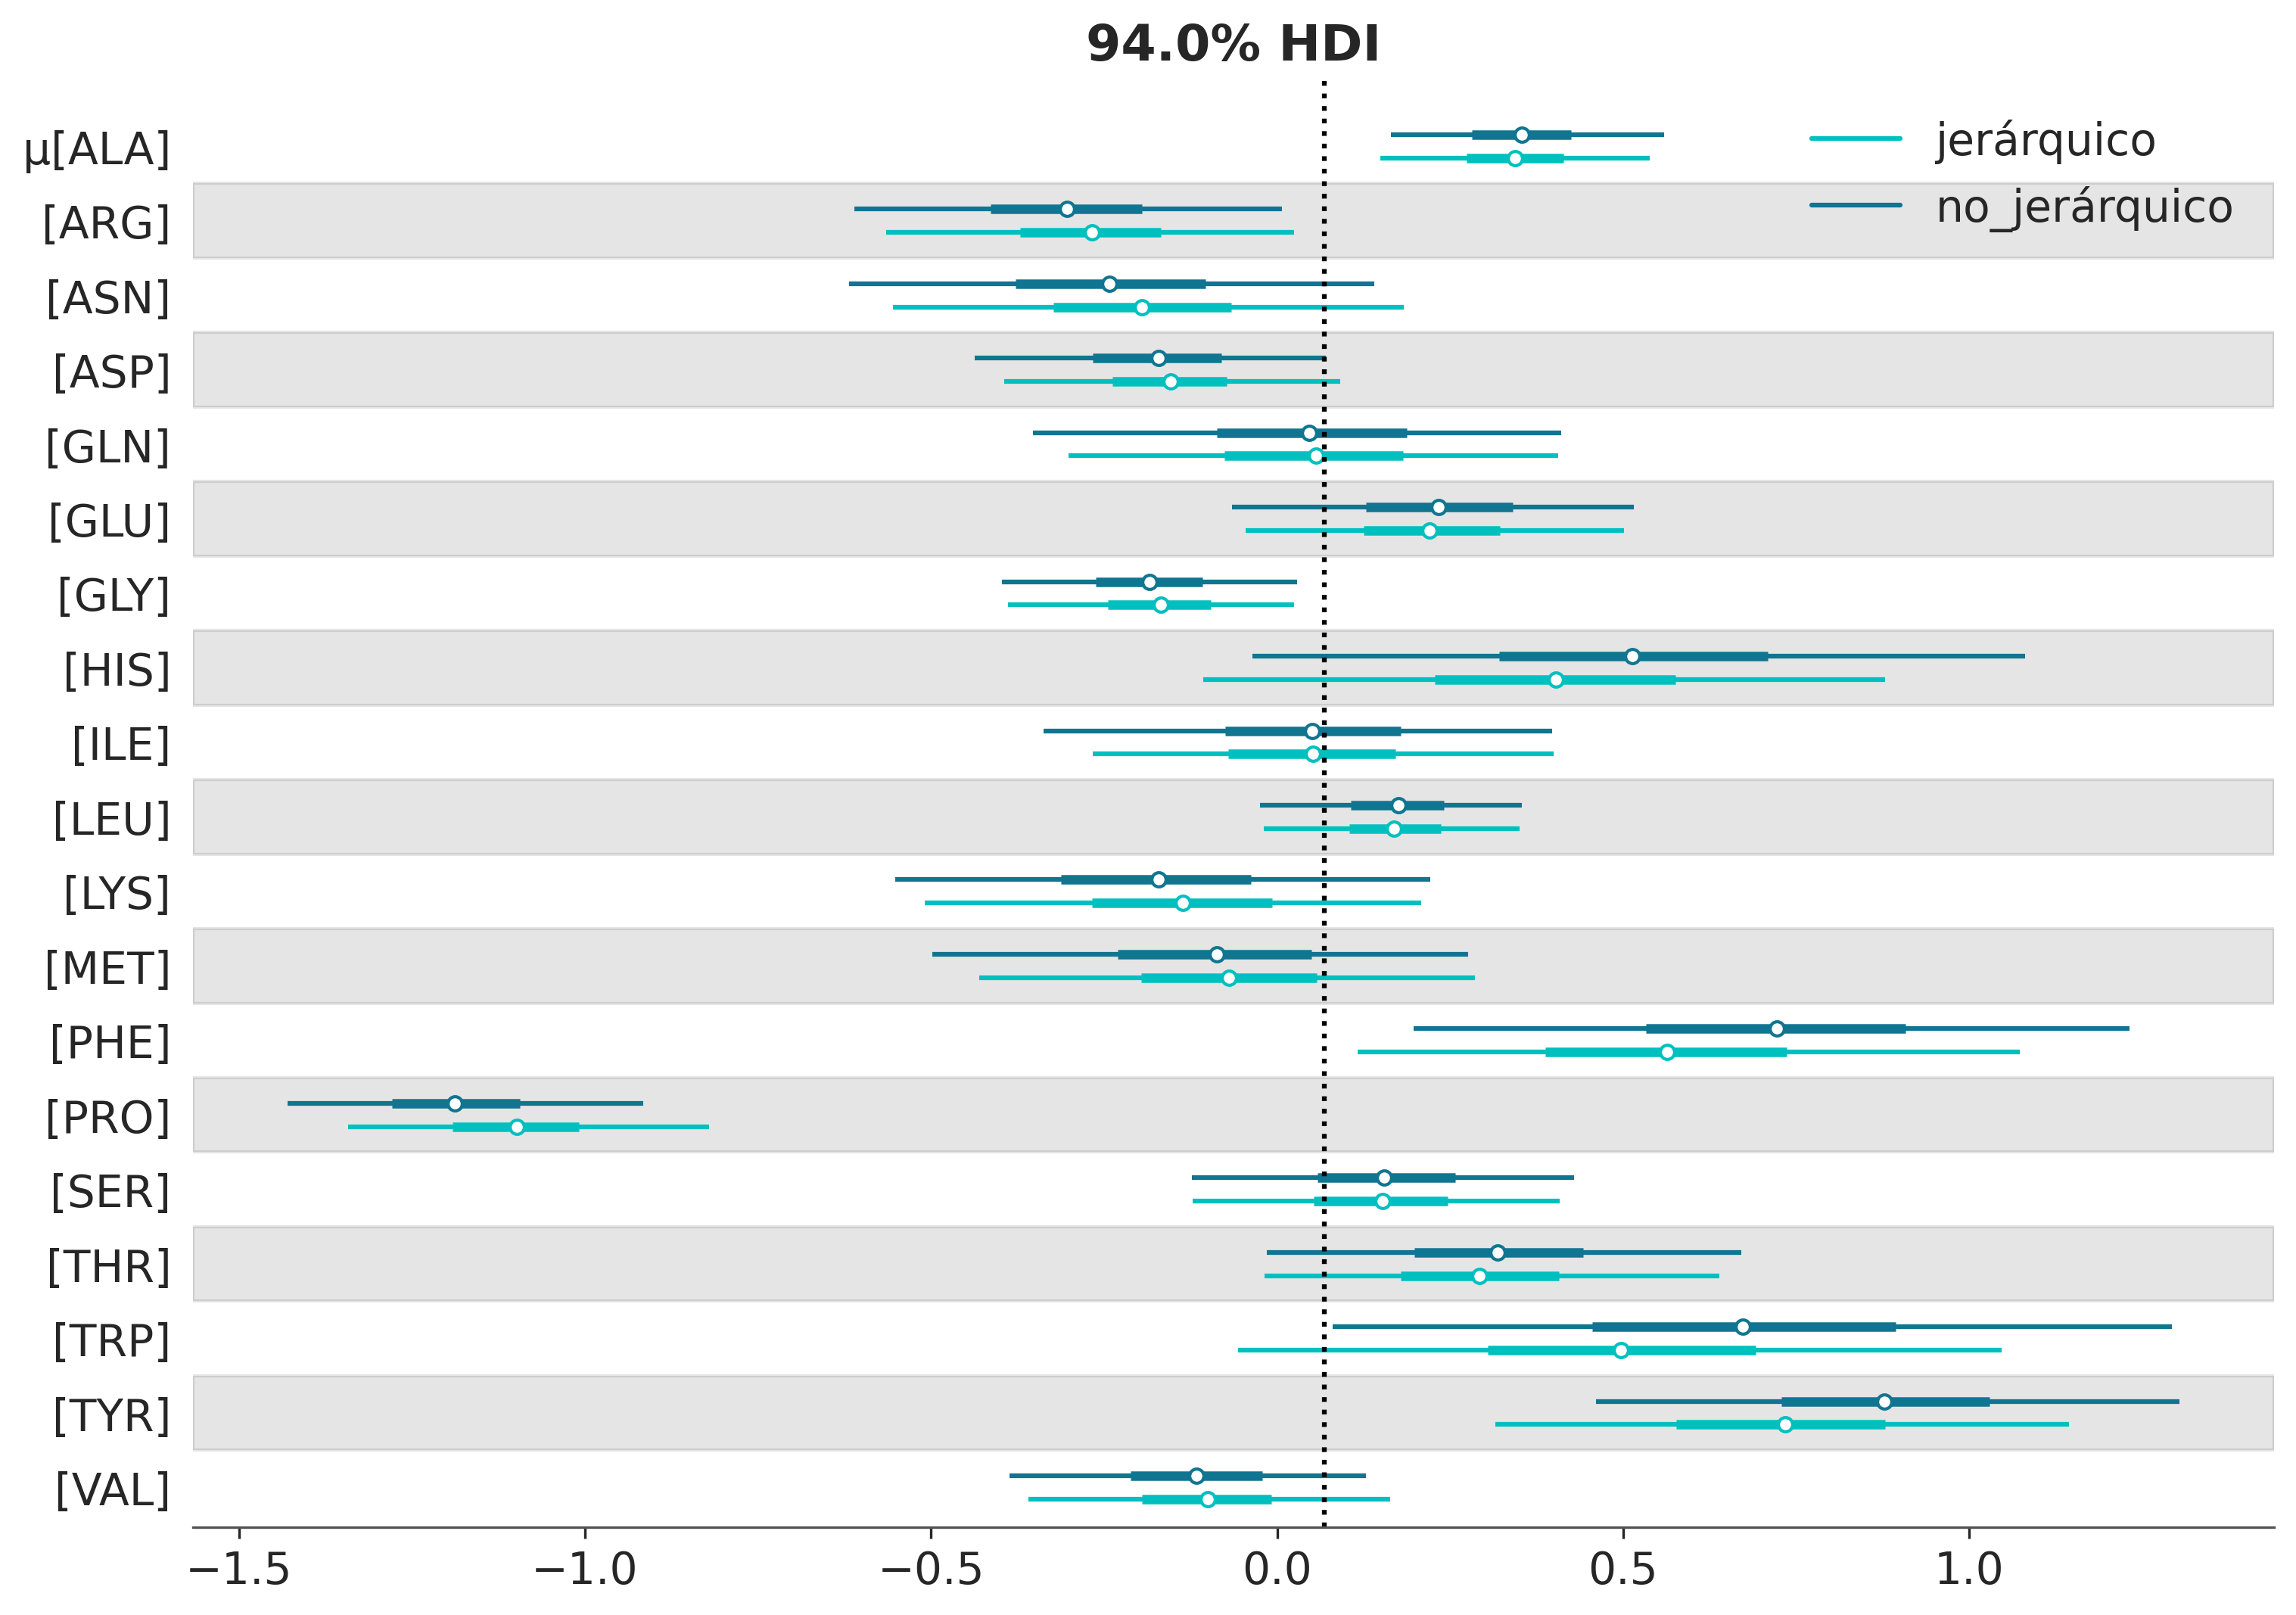

In [8]:
axes = az.plot_forest([idata_cs_nh, idata_cs_h], model_names=['no_jerárquico', 'jerárquico'],
                      var_names='μ', combined=True, r_hat=False, ess=False, figsize=(10, 7),
                      colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

> En un modelo jerárquico, los grupos que comparten un hiperprior común comparten información a través de ese hiperprior. 
Esto da como resultado una _contracción_ de las estimaciones, respecto del modelo desagrupado.

## Es deseable tener contracción?

## Renacuajos multinivel

Este ejemplo está tomado de [statistical rethinking](https://xcelab.net/rm/statistical-rethinking/)

* Tenemos 48 tanques llenos de renacuajos

* Queremos modelar la probabilidad de supervivencia de los renacuajos

* Las condiciones como la temperatura, el pH, la luz, etc. varían ligeramente entre los tanques (pero no los estamos teniendo en cuenta explícitamente)

* Podemos pensar en cada tanque como un grupo


In [9]:
d = pd.read_csv('../datos/renacuajos.csv', sep=",")
coords = {"tanks": list(d.index)}
d.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [10]:
with pm.Model(coords=coords) as modelo_renacuajos:
    # Hiperpriors
    μ = pm.Normal('μ', 0., 2.)
    σ = pm.HalfNormal('σ', 2.)
    # Prior
    α_tanque = pm.Normal('α_tanque', μ, σ, dims="tanks")
    p = pm.Deterministic('p', pm.math.sigmoid(α_tanque))  # transformación logística
    #likelihood
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    
    idata_renacuajos = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, α_tanque]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


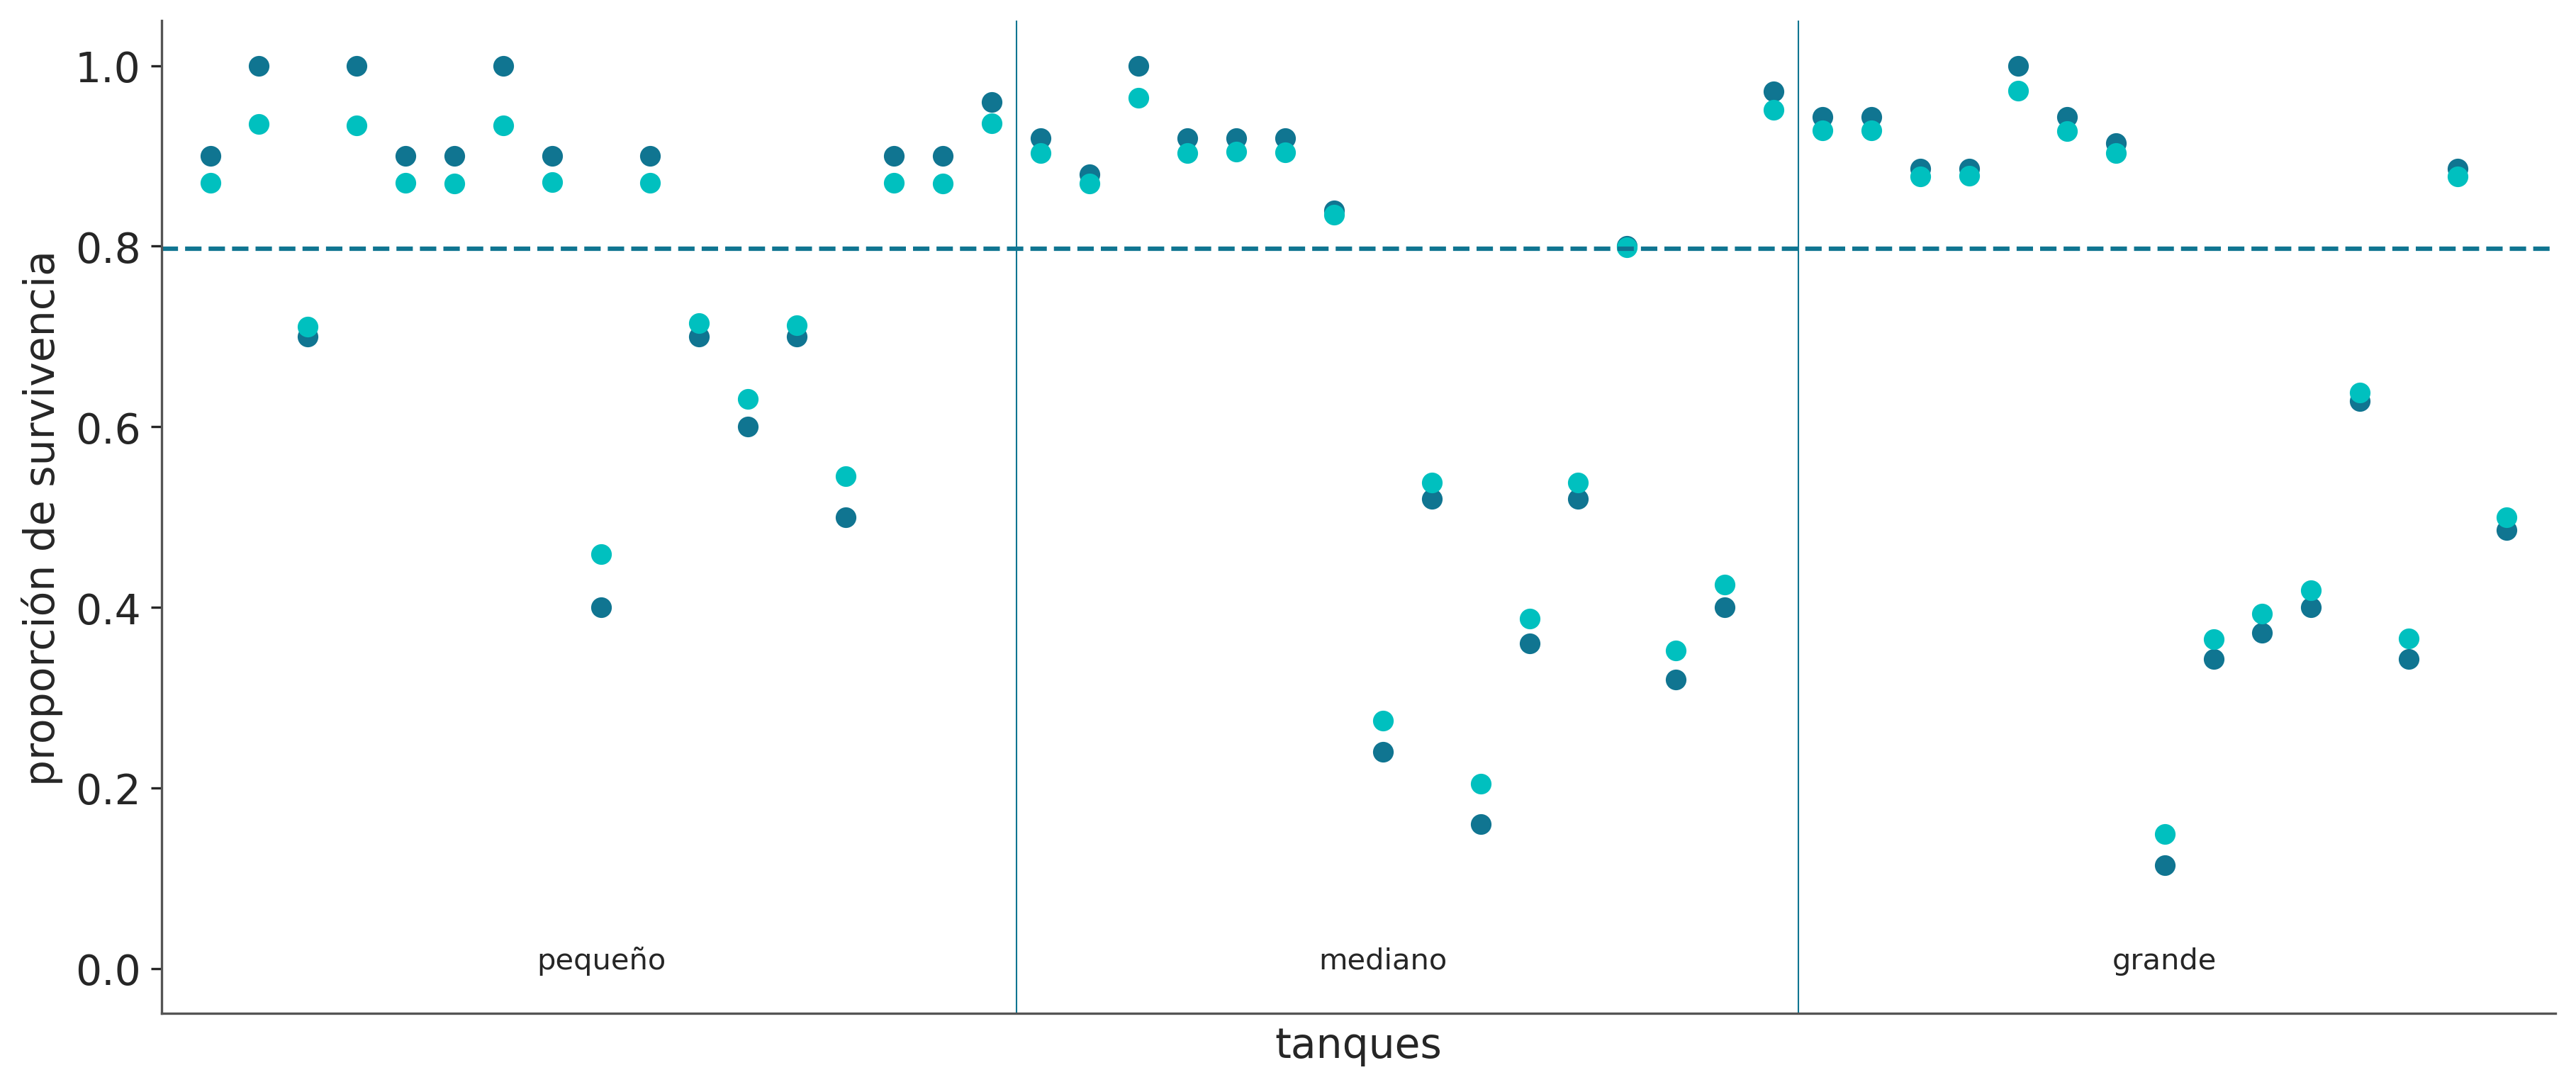

In [11]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))

post_r = az.extract(idata_renacuajos)

ax.scatter(np.arange(0, 48), d.propsurv, color='C0')
ax.scatter(np.arange(0, 48), post_r['p'].mean("sample"), color='C1')
ax.hlines(logistic(post_r['μ'].median("sample")), -1, 49, linestyles='--')

idx = d.density[d.density.diff() > 0].index
ax.vlines(idx + 0.5, -.05, 1.05, lw=.5)
for i, t in zip(np.linspace(0, 48, 7)[1::2], ('pequeño', 'mediano', 'grande')):
    ax.text(i, 0, t, horizontalalignment='center')
ax.set_xlabel('tanques')
ax.set_ylabel('proporción de survivencia')
ax.set_xlim(-1, 48)
ax.set_xticks([])
ax.set_ylim(-.05, 1.05)
ax.grid(False)

## Intercambiabilidad (exchangeability)

> Una secuencia, finita o infinita de variables aleatorias $X_1, X_2, X_3, \dots X_j$ es intercambiable si su distribución de probabilidad conjunta no se ve modificada por permutaciones de los indices $(1, \dots, J)$. 



* Tenemos una bolsa con una bola blanca y una negra. 

* La probabilidad de sacar cualquiera de ellas es de 0.5. 

* Si $X_i = 1$ indica que la iésima bola es blanca y muestreando sin reemplazo, tendremos que:


$$P(X_1=1, X_2=0) = 0.5$$
$$P(X_1=0, X_2=1) = 0.5$$

Como la probabilidad no cambia al cambiar el orden, $X_1$ e $X_2$ son intercambiables.

Ahora bien, también es cierto que:

$$P(X_2=1 \mid X_1=1) = 0$$
$$P(X_2=1) = 0.5$$

Por lo tanto $X_1$ e $X_2$ no son independientes.



> Toda secuencia iid es también intercambiable, pero una secuencia intercambiable no es necesariamente iid. La condición de intercambialidad es más general (o menos *estricta*) que la de independencia.



Sea $x_i \mathop{\sim}\limits^{iid} p(x)$, tenemos que la probabilidad conjunta se calcula como el producto de las probabilidades marginales:


$$p(x_i, \dots , x_n) = \prod_i^n p(x_i)$$


Dado que el producto es conmutativo, tenemos que el resultado es invariante a permutaciones.

## Teorema de De Finetti

Una secuencia de variables aleatorias es intercambiable si y solo si para todo $n$ podemos escribir:


$$p(X_1, X_2,  \dots , X_n) = \int \prod_i^n p(X_i \mid \theta) \; p(\theta)$$

Es decir, que un conjunto de variable aleatorias puede ser descrito por:

* un parámetro $\theta$
* un likelihood $p(X \mid \theta)$
* un prior $p(\theta)$

* La trampa, por que siempre hay una trampa, es que el teorema no nos dice nada sobre como elegir ni el parámetro, ni el likelihood ni el prior. 

* Existen algunas justificaciones teóricas para elegir estos elementos, pero no lo discutiremos en este curso, principalmente por su limitada utilidad práctica.

Supongamos ahora que $\theta$ representa un conjunto de parámetros, $\theta = (\theta_1, \theta_2,  \dots , \theta_n)$ y que este conjunto de parámetros es intercambiable. Entonces podemos escribir:

$$(\theta_1, \theta_2,  \dots , \theta_n) = \int \prod_i^n p(\theta_i \mid \psi) \; p(\psi)$$


Obteniendo un modelo jerárquico que podríamos reescribir como:


\begin{align*}
X_{ij} &\sim p(X \mid \theta_i) \\
\theta_i &\sim p(\theta \mid \psi)  \\
\psi &\sim p(\psi) 
\end{align*}

## Intercambiabilidad e inferencia

Yo he seleccionado 10 valores de desplazamientos químicos $y_1, \dots, y_{10}$. Qué me pueden decir del valor $y_4$? 


Bien, ahora supongamos que les muestro 9 valores, excepto $y_4$, qué pueden decir de $y_4$?

| $y_1$   | $y_2$   | $y_3$   | $y_5$   | $y_6$   | $y_7$   | $y_8$   | $y_9$   | $y_{10}$   |
|---------|---------|---------|---------|---------|---------|---------|---------|------------|
| 58.27   | 56.18   | 56.84   | 54.64   | 54.2    | 57.51   | 44.45   | 61.46   | 54.45      |


